# NodeConstructor Demo

This notebook is intended to show the functionality of the NodeConstructor class. The class is used to generate the ODE system of a grid. The grid can ether be externally specified or randomly generated by the class itself. The goal is then to create the grid given the parameters of the objects within and generate the ODEs, which will then be output in the state space representation and can be solved via `control.ss()` ([Source](https://python-control.readthedocs.io/en/latest/generated/control.ss.html#control.ss)) or `scipy.signal` ([Source](https://docs.scipy.org/doc/scipy/reference/signal.html#continuous-time-linear-systems)).

First of all make sure the repo is installed as package. Go to path-to-dir/dare and run  `python -m pip install -e .`.

In [1]:
import numpy as np

### Import the class

In [3]:
from pre_investigations.python.dare.utils.nodeconstructor import NodeConstructor

In [4]:
NodeConstructor

pre_investigations.python.dare.utils.nodeconstructor.NodeConstructor

### Create a grid with 2 sources and 1 load

For the first example, a previously defined grid is to be constructed by setting up the connection matrix (CM) by hand.

The grid corresponds to this circuit diagram:

![](./images/MG_2_node_Singleline-1.png)

In [5]:
# define parameters

R = 0.4
L = 2.3e-3
C = 10e-6
LT = 2.3e-3
R_load = 14

parameter = dict()
parameter['R_source'] = R
parameter['L_source'] = L
parameter['C_source'] = C
parameter['L_cabel'] = LT
parameter['R_cabel'] = R
parameter['R_load'] = R_load

An entry in the CM reads as follows: Object x (row) is connected to object y (column) via connection line z.

x ---z---> y

The rows and columns are arranged in such a way that first only sources and then only loads are noted. For this example we need 2 sources and 1 load, so the following is a CM of size 3x3. The connection from the first source to the load is then marked by the entry "1" in `CM[0,2]` (See cell below). For the second source to the load the entry "2" follows `CM[1,2]`. Since a source cannot be connected to itself, there are only zeros on the main diagonal.

In [6]:
# set up CM

CM = np.array([[0, 0, 1],
               [0, 0, 2],
               [-1, -2, 0]])

In [7]:
# grid with 2 sources, 1 load and a total of 2 connections

Grid_S2_L1_2C = NodeConstructor(2, 1, parameter, CM = CM)

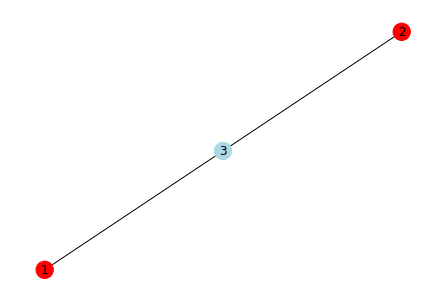

In [8]:
# corresponding graph

Grid_S2_L1_2C.draw_graph()

Now let's consider the case where we want to create a grid without the input of a CM. Let's create a network where all objects are connected. To keep it simple, we stick to 2 sources and 1 load.

To do this, we now set the probability of a connection S2S and S2L both to 1.

In [9]:
Grid_FC = NodeConstructor(2, 1, parameter, S2S_p=1, S2L_p=1)

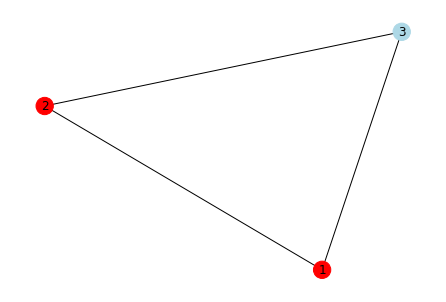

In [10]:
Grid_FC.draw_graph()

A special case that is caught in the code is the random creation of subnets. This is to ensure that a network with the desired number of sources and loads is provided. To test this, a network can be created and the connection probabilities set to 0. In the result you will see that nevertheless a minimum number of connections was drawn to connect all elements of the grid. The selection of which elements are then connected to each other is again made randomly. Run the code several times and watch how the connections change.

In [11]:
Grid_NC = NodeConstructor(4, 4, parameter, S2S_p=0, S2L_p=0)

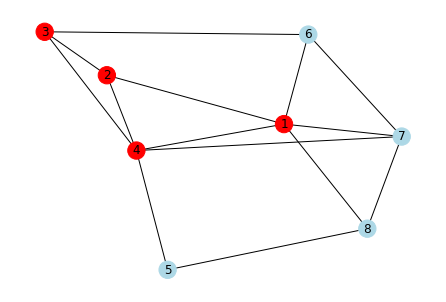

In [12]:
Grid_NC.draw_graph()

### Bigger grids and evaluation

Now we want to create a grid with 5 sources and 5 loads, keeping the probabilities at the default values. 

In [13]:
Grid_S5_L5 = NodeConstructor(5, 5, parameter)

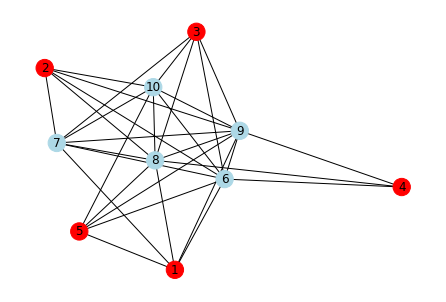

In [14]:
Grid_S5_L5.draw_graph()

In order to evaluate this network, the get function can be called, which returns the state space matrixes.

In [15]:
A, B, C, D = Grid_S5_L5.get_sys()

In [16]:
# or scipy.lti
import control
import matplotlib.pyplot as plt

In [17]:
sys = control.ss(A, B, C, D)

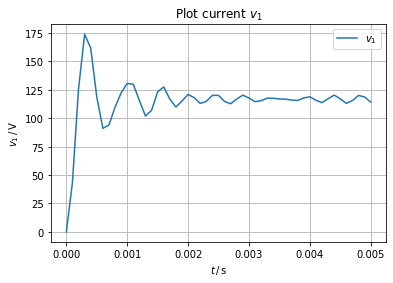

In [18]:
# define time vector
ts = 1e-4
t_end = 0.005
steps = int(1/ts)
t = np.arange(0, t_end+ts, ts)
num_samples = len(t)

# generate init state
x0 = np.zeros((A.shape[0],1))

# simple input signal of constant 230V from all sources
u = np.array([230]).repeat(Grid_S5_L5.num_source)[:,None] * np.ones((Grid_S5_L5.num_source,len(t)))

T, yout, xout = control.forced_response(sys, T=t, U=u, X0=x0, return_x=True, squeeze=True)

plt.plot(t, xout[1], label='$v_1$')
plt.xlabel(r'$t\,/\,\mathrm{s}$')
plt.ylabel('$v_{\mathrm{1}}\,/\,\mathrm{V}$')
plt.title('Plot current $v_1$')
plt.legend()
plt.grid()
plt.show()